# Tutorial3: Logistic Regression

Simple logistic regression example in TensorFlow. Using the The [notMNIST](http://yaroslavvb.blogspot.com.br/2011/09/notmnist-dataset.html) dataset. Reference [cs20si](http://web.stanford.edu/class/cs20si/lectures/slides_03.pdf)

In [1]:
# All imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from util import get_log_path, plot9images, get_data, get_batch

%matplotlib inline


### First we need to get the data. You can find the preprocessed data [here](https://www.dropbox.com/s/t5l172b417p9pf1/notMNIST.zip?dl=0)

In [2]:
# uncomment the code below to download and extract the data
#! bash download.sh

In [3]:
train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels = get_data()
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000, 10)
Validation: (10000, 28, 28) (10000, 10)
Testing: (10000, 28, 28) (10000, 10)


### Visualizing some examples

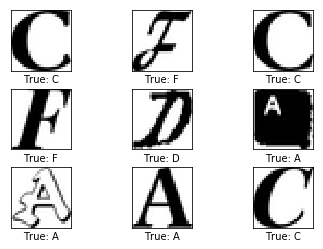

In [4]:
train_classes = np.argmax(train_labels, axis=1)
train_classes = [chr(i + ord('A')) for i in train_classes]
img_size = 28
img_shape = (img_size, img_size)
images = train_dataset[0:9]
cls_true = train_classes[0:9]
plot9images(images, cls_true, img_shape)

### As before, we use the class Config to store all the hyperparameters

In [5]:
class Config():
    """
    Class to hold all model hyperparams.

    :type learning_rate: float
    :type batch_size: int
    :type image_size: int
    :type num_classes: int
    :type num_features: int
    :type num_epochs: int
    :type show_epoch: int
    :type log_path: None or str
    """
    def __init__(self,
                 learning_rate=0.001,
                 image_size=28,
                 batch_size=128,
                 num_classes=10,
                 num_features=784,
                 num_epochs=101,
                 show_epoch=10,
                 log_path=None):

        self.learning_rate = learning_rate
        self.image_size = image_size
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.num_features = num_features
        self.num_epochs = num_epochs
        self.show_epoch = show_epoch
        if log_path is None:
            self.log_path = get_log_path()
        else:
            self.log_path = log_path

###  We also use a class to store all the data information

In [6]:
class DataHolder:
    """
    All data information

    :type train_dataset: numpy array
    :type train_labels: numpy array
    :type valid_dataset: numpy array
    :type valid_labels: numpy array
    :type test_dataset: numpy array
    :type test_labels: numpy array
    """
    def __init__(self,
                 train_dataset,
                 train_labels,
                 valid_dataset,
                 valid_labels,
                 test_dataset,
                 test_labels):

        self.train_dataset = train_dataset
        self.train_labels = train_labels
        self.valid_dataset = valid_dataset
        self.valid_labels = valid_labels
        self.test_dataset = test_dataset
        self.test_labels = test_labels


### Defining the logistic regression model as a tf graph

In [7]:
class LogisticRegression:
    """
    Logistic regression model
    
    :type config: Config
    """
    def __init__(self, config):

        self.learning_rate = config.learning_rate
        self.log_path = config.log_path
        self.batch_size = config.batch_size
        self.num_classes = config.num_classes
        self.num_features = config.num_features 
        self.build_graph()

    def create_placeholders(self):
        """
        Method for creating placeholders for input X (image)
        and label Y (one-hot vector).
        """
        self.X = tf.placeholder(tf.float32,
                                shape=(self.batch_size , self.num_features),
                                name="X")
        self.Y = tf.placeholder(tf.float32,
                                shape=(self.batch_size, self.num_classes),
                                name="Y")

    def create_variables(self):
        """
        Method for creating weight and bias variables.
        """
        with tf.name_scope("Weights"):
            w_shape = (self.num_features, self.num_classes)
            b_shape = (self.num_classes)
            w_init = tf.zeros(w_shape)
            b_init = tf.zeros(b_shape)
            self.weight = tf.get_variable("w", dtype=tf.float32, initializer=w_init)
            self.bias = tf.get_variable("b", dtype=tf.float32, initializer=b_init)

    def create_summaries(self):
        """
        Method to create the histogram summaries for all variables
        """
        tf.summary.histogram('weights_summ', self.weight)
        tf.summary.histogram('bias_summ', self.bias)

    def create_logits(self):
        """
        Method for creating logits: (X * W) + b
        """
        with tf.name_scope("logits"):
            self.logits = tf.add(tf.matmul(self.X,self.weight),
                                 self.bias,
                                 name="logits")

    def create_loss(self):
        """
        Method for calculating the loss function 
        unsing softmax and cross entropy.
        """
        with tf.name_scope("loss"):
            entropy_loss = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,
                                                                   labels=self.Y)
            self.loss = tf.reduce_mean(entropy_loss)
            tf.summary.scalar("loss",self.loss)

    def create_optimizer(self):
        """
        Method to create the optimizer of the graph
        """
        with tf.name_scope("optimizer"):
            opt = tf.train.GradientDescentOptimizer(self.learning_rate)
            self.optimizer = opt.minimize(self.loss)

    def create_predictions(self):
        """
        Method to create the prediction for the placeholder.
        """
        with tf.name_scope("prediction"):
            prob_prediction = tf.nn.softmax(self.logits,
                                            name='X_prob_prediction')
            self.prediction = tf.argmax(prob_prediction,
                                        1,
                                        name='X_prediction')
            self.labes_cls = tf.argmax(self.Y,
                                       1,
                                       name='ground_truth')


    def create_accuracy(self):
        """
        Method to compute the accuracy of the model's predictions
        """
        with tf.name_scope('accuracy'):
            correct_pred = tf.equal(self.prediction,
                                    self.labes_cls)
            self.acc = tf.reduce_mean(tf.cast(correct_pred, 'float'))
            tf.summary.scalar('accuracy', self.acc)

    # Now we are going to save the variables after the training
    def create_saver(self):
        """
        Method to create the graph saver.
        """
        self.saver = tf.train.Saver()
        save_dir = 'checkpoints/'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        self.save_path = os.path.join(save_dir, 'best_validation')
            
    def build_graph(self):
        """
        Method to build the computation graph in tensorflow
        """
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.create_placeholders()
            self.create_variables()
            self.create_summaries()
            self.create_logits()
            self.create_loss()
            self.create_optimizer()
            self.create_predictions()
            self.create_accuracy()
            self.create_saver()


Using tensorboard to visualize the graph:
![image](./images/graph_logistic_regression.png)

### Function to train the model

In [8]:
def run_training(model, config, dataholder, verbose=True):
    """
    Train the logistic regression model

    :type model: LogisticRegression
    :type config: Config
    :type dataholder: DataHolder
    :type verbose: boolean
    """
    train_data = dataholder.train_dataset
    num_samples = train_data.shape[0]
    num_features = config.num_features
    train_data = train_data.reshape((num_samples, num_features))
    train_labels = dataholder.train_labels
    valid_data = dataholder.valid_dataset
    valid_data = valid_data.reshape((valid_data.shape[0], num_features))
    valid_labels = dataholder.valid_labels
    batch_size = config.batch_size
    show_epoch = config.show_epoch
    num_epochs = config.num_epochs
    log_path = model.log_path
    with tf.Session(graph=model.graph) as sess:
        if verbose:
            print('Start training\n')
        summary_writer = tf.summary.FileWriter(log_path,sess.graph)
        all_summaries = tf.summary.merge_all() 
        tf.global_variables_initializer().run()
        step = 0
        best_valid_acc = 0 
        num_batches = int(num_samples/batch_size)
        for i in range(num_epochs):
            total_loss = 0
            for _ in range(num_batches):
                step += 1
                X_batch, Y_batch = get_batch(train_data,
                                             train_labels,
                                             batch_size)
                feed_dict = {model.X: X_batch, model.Y: Y_batch}
                _, loss_batch, acc, summary = sess.run([model.optimizer,
                                                        model.loss,
                                                        model.acc,
                                                        all_summaries],
                                                  feed_dict=feed_dict)
                summary_writer.add_summary(summary,step)
                summary_writer.flush()
                
                total_loss += loss_batch
            if i % show_epoch == 0:
                X_batch_valid, Y_batch_valid = get_batch(valid_data,
                                                         valid_labels,
                                                         batch_size)
                feed_dict = {model.X: X_batch_valid, model.Y: Y_batch_valid}
                valid_acc = sess.run(model.acc,feed_dict=feed_dict)
                print('Average loss epoch {0}: {1}'.format(i, total_loss/num_batches))
                print('Minibatch acc epoch {}: {:.2f}%'.format(i, acc*100))
                print('Valid minibatch acc epoch {}: {:.2f}%\n'.format(i, valid_acc*100))
                if valid_acc > best_valid_acc:
                        best_valid_test = valid_acc
                        model.saver.save(sess=sess,
                                         save_path=model.save_path)
        if verbose:
            print("\n========= For TensorBoard visualization type ===========")
            print("\ntensorboard  --logdir={}\n".format(log_path))



### Training the model

In [9]:
my_config = Config()
my_model = LogisticRegression(my_config)
my_dataholder = DataHolder(train_dataset,
                           train_labels,
                           valid_dataset,
                           valid_labels,
                           test_dataset,
                           test_labels)

run_training(my_model, my_config, my_dataholder)

Start training

Average loss epoch 0: 1.4004583119506566
Minibatch acc epoch 0: 78.12%
Valid minibatch acc epoch 0: 72.66%

Average loss epoch 10: 0.7023494824213805
Minibatch acc epoch 10: 90.62%
Valid minibatch acc epoch 10: 85.16%

Average loss epoch 20: 0.6746683462061436
Minibatch acc epoch 20: 78.91%
Valid minibatch acc epoch 20: 82.81%

Average loss epoch 30: 0.6628305920031251
Minibatch acc epoch 30: 82.03%
Valid minibatch acc epoch 30: 82.03%

Average loss epoch 40: 0.647111483080439
Minibatch acc epoch 40: 88.28%
Valid minibatch acc epoch 40: 81.25%

Average loss epoch 50: 0.6460892685358717
Minibatch acc epoch 50: 79.69%
Valid minibatch acc epoch 50: 78.12%

Average loss epoch 60: 0.64580037441968
Minibatch acc epoch 60: 79.69%
Valid minibatch acc epoch 60: 80.47%

Average loss epoch 70: 0.637868017969455
Minibatch acc epoch 70: 87.50%
Valid minibatch acc epoch 70: 83.59%

Average loss epoch 80: 0.6345975462361578
Minibatch acc epoch 80: 85.16%
Valid minibatch acc epoch 80: 

In [10]:
# ! tensorboard  --logdir=

### Now that we have trained the model and save it variables in the folder "checkpoints"  we can use it to predict the labels of some images from the test dataset

In [11]:
def prediction(model, config, dataholder):
    """
    Generate some predictions using a batch from the test dataset

    :type model: LogisticRegression
    :type config: Config
    :type dataholder: DataHolder
    :rtype images: np array
    :rtype prediction: np array
    :rtype ground_truth: np array
    """
    num_features = config.num_features
    test_data = dataholder.test_dataset
    test_data = test_data.reshape((test_data.shape[0], num_features))
    test_labels = dataholder.test_labels
    batch_size = config.batch_size
    img_size = config.image_size
    with tf.Session(graph=model.graph) as sess:
        # We load the saved variables
        model.saver.restore(sess=sess, save_path=model.save_path)
        X_batch, Y_batch = get_batch(test_data,
                                     test_labels,
                                     batch_size)
        feed_dict = {model.X: X_batch, model.Y: Y_batch}
        acc, predictions = sess.run([model.acc,
                                  model.prediction],
                                  feed_dict=feed_dict)
        print('Test minibatch acc {:.2f}%'.format(acc*100))
    ground_truth = np.argmax(Y_batch, axis=1)
    images = X_batch.reshape((X_batch.shape[0], img_size, img_size))
    return images, predictions, ground_truth 

In [12]:
images, batch_prediction, batch_ground_truth = prediction(my_model,
                                                          my_config,
                                                          my_dataholder)

Test minibatch acc 86.72%


### And we can see if our predictions make sense

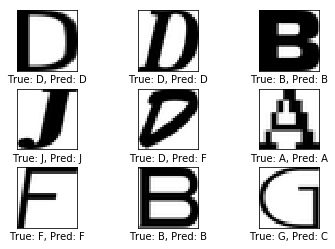

In [13]:
batch_prediction = [chr(i + ord('A')) for i in batch_prediction]
batch_ground_truth = [chr(i + ord('A')) for i in batch_ground_truth]
images = images[0:9]
cls_true = batch_ground_truth[0:9]
cls_pred = batch_prediction[0:9] 
plot9images(images, cls_true, img_shape,cls_pred)